In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import sampyl as smp
from sampyl import np
import autograd.scipy.stats.norm as norm
from black_box_svi import black_box_variational_inference
from autograd.optimizers import adam
import autograd.scipy.stats.multivariate_normal as mvn
np.random.seed(42)

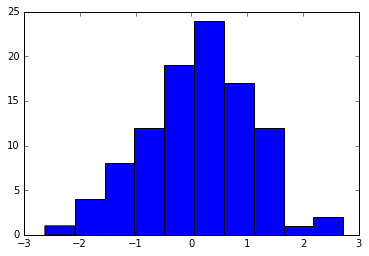

In [79]:
# generate some data from a mixture of 2 gaussians
N = 100
mean = 1
std = 10
x = np.zeros(N)
m1 = -0.5
m2 = 0.5
xstd = 0.8
for n in range(N):
    p = np.random.rand()
    if p > 0.5:
        x[n] = m1 + xstd * np.random.randn()
    else:
        x[n] = m2 + xstd * np.random.randn()
        
_ = plt.hist(x, bins=10)

In [80]:
# log prob
def log_prob(m):
    m = np.array(m).reshape([2,])
    m1, m2 = m[0], m[1]
    p1 = norm.pdf(m1, -mean, std)
    p2 = norm.pdf(m2, mean, std)
    p3 = np.prod(0.5 * norm.pdf(x, m1, xstd) + 0.5 * norm.pdf(x, m2, xstd))
    return np.log(p1 * p2 * p3)

0 10201
1000 10201
2000 10201
3000 10201
4000 10201
5000 10201
6000 10201
7000 10201
8000 10201
9000 10201
10000 10201


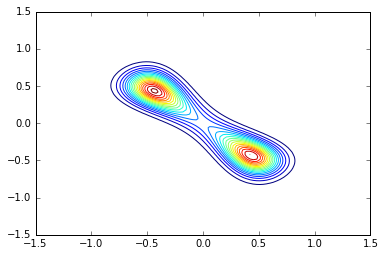

In [81]:
# plot the exact density
x = np.linspace(-1.5, 1.5, num=101)
y = np.linspace(-1.5, 1.5, num=101)
X, Y = np.meshgrid(x, y)
X_ravel = X.ravel()
Y_ravel = Y.ravel()
zs = np.zeros_like(X_ravel)
for i in range(X_ravel.shape[0]):
    if i % 1000 == 0:
        print i, X_ravel.shape[0]
    zs[i] = np.exp(log_prob([X_ravel[i], Y_ravel[i]]))
Z = zs.reshape(X.shape)
plt.contour(X, Y, Z, 20)

Progress: [##############################] 2100 of 2100 samples


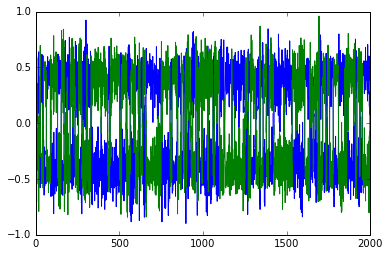

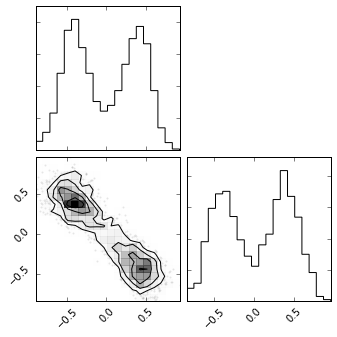

In [82]:
# sample using HMC
start = smp.find_MAP(log_prob, {'m': np.random.randn(2)})
ham = smp.Hamiltonian(log_prob, start, step_size=0.1)
chain = ham.sample(2100, burn=100)
samples = chain.m
# plot samples
_ = plt.plot(samples)
import corner
figure = corner.corner(samples)

[ 0.35284703 -0.43627042] [ 0.02579015  0.0288796 ]


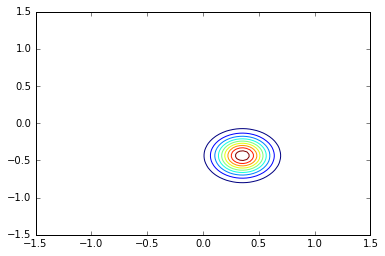

In [83]:
## We now run mean field variational inference

# Set up plotting code
def plot_pdf(func, xlimits=[-1.5, 1.5], ylimits=[-1.5, 1.5], numticks=101):
    # Set up figure.
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z, 10)
    ax.set_xlim(xlimits)
    ax.set_xlim(xlimits)
        
def plot_results(params):
    mean, log_std = unpack_params(params)
    print mean, np.exp(2*log_std)
    variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
    plot_pdf(variational_contour)
# Build variational objective.
D = 2
objective, gradient, unpack_params = \
    black_box_variational_inference(log_prob, D, num_samples=1)
init_mean    = np.random.randn(D)
init_log_std = -2 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
variational_params = adam(gradient, init_var_params, step_size=0.01, num_iters=600)
plot_results(variational_params)

epoch 0/50
epoch 10/50
epoch 20/50
epoch 30/50
epoch 40/50
0.377677514881 -0.40767267838 0.0245943819236 0.0245942119622


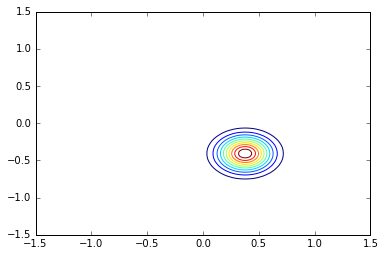

In [84]:
# we now run expectation propagation
def logZ(params, x, xnoise):
    m1, v1 = params[0], params[1]
    m2, v2 = params[2], params[3]
    
    C1 = 1.0 / (1.0/v1 + 1.0/xnoise)
    c1 = C1*m1/v1 + C1*x/xnoise
    zc1 = np.sqrt(C1/xnoise/v1/(2*np.pi))
    zc1 *= np.exp(-0.5*(m1**2/v1 + x**2/xnoise - c1**2/C1))
    
    C2 = 1.0 / (1.0/v2 + 1.0/xnoise)
    c2 = C2*m2/v2 + C2*x/xnoise
    zc2 = np.sqrt(C2/xnoise/v2/(2*np.pi))
    zc2 *= np.exp(-0.5*(m2**2/v2 + x**2/xnoise - c2**2/C2))
    
    Z = 0.5 * (zc1 + zc2)
    return np.log(Z)
from autograd import grad
grad_logZ = grad(logZ)
# init factors
m1_t1 = np.zeros(N)
m1_t2 = np.zeros(N)
m2_t1 = np.zeros(N)
m2_t2 = np.zeros(N)
p1_t1 = 1.0/std**2
p1_t2 = p1_t1*mean
p2_t1 = 1.0/std**2
p2_t2 = -p2_t1*mean

no_epochs = 50
for e in range(no_epochs):
    if e % 10 == 0:
        print 'epoch %d/%d' % (e, no_epochs)
    for n in range(N):
        # compute cavity
        c1_t1 = p1_t1 + np.sum(np.delete(m1_t1, n))
        c1_t2 = p1_t2 + np.sum(np.delete(m1_t2, n))
        c2_t1 = p2_t1 + np.sum(np.delete(m2_t1, n))
        c2_t2 = p2_t2 + np.sum(np.delete(m2_t2, n))
        c1_v = 1/c1_t1
        c1_m = c1_v*c1_t2
        c2_v = 1/c2_t1
        c2_m = c2_v*c2_t2
        
        # compute gradients of logZ
        grads = grad_logZ(np.array([c1_m, c1_v, c2_m, c2_v]),
                         x[n], xstd**2)
        grad_c1_m = grads[0]
        grad_c1_v = grads[1]
        grad_c2_m = grads[2]
        grad_c2_v = grads[3]
        
        # compute new posterior
        po1_m = c1_m + c1_v*grad_c1_m
        po1_v = c1_v - c1_v**2 * (grad_c1_m**2 - 2*grad_c1_v)
        
        po2_m = c2_m + c2_v*grad_c2_m
        po2_v = c2_v - c2_v**2 * (grad_c2_m**2 - 2*grad_c2_v)
        
        po1_t1 = 1.0 / po1_v
        po1_t2 = po1_t1 * po1_m
        po2_t1 = 1.0 / po2_v
        po2_t2 = po2_t1 * po2_m
        
        # update factor
        m1_t1[n] = po1_t1 - c1_t1
        m1_t2[n] = po1_t2 - c1_t2
        m2_t1[n] = po2_t1 - c2_t1
        m2_t2[n] = po2_t2 - c2_t2

# compute posterior
po1_t1 = p1_t1 + np.sum(m1_t1)
po1_t2 = p1_t2 + np.sum(m1_t2)
po2_t1 = p2_t1 + np.sum(m2_t1)
po2_t2 = p2_t2 + np.sum(m2_t2)
p1_v = 1/po1_t1
p1_m = po1_v*po1_t2
p2_v = 1/po2_t1
p2_m = po2_v*po2_t2
print p1_m, p2_m, p1_v, p2_v
posterior_contour = lambda x: mvn.pdf(x, [p1_m, p2_m], 
                                      np.diag([p1_v, p2_v]))
plot_pdf(posterior_contour)